# Ground Truth

We obtained a set of time-lapse microscopy images from CAR-T experiments performed on an IncuCyte machine. Images of cell populations in microplate wells were taken every two hours over a three day period. In this paper we consider the most basic setting, consisting only of cells from the Raji cell line, a cancer cell line originally derived from human B cells. Note that our methodology should naturally extend to other experimental settings, such as those involving T cells, which we intend to address in future work. Our learning task therefore comprises two cell phenotypes: living and dead. The image frames consist of a phase contrast image and corresponding mCherry and green fluorescent protein (GFP) overlays. The mCherry fluorescence is present in all Raji cells while the GFP only appears in dead cells. Our ultimate objective is to track the respective cell phenotype numbers over time.

The fluorescent markers of our image set provide a quasi-ground truth annotation for the corresponding phase contrast image. Such a provision in principle obviates the need of laborious manual annotation, except for evaluation purposes.

Our pipeline begins by applying a Gaussian filter ($\sigma = 2$) to the phase contrast image. We then segment cells by subtracting a background image formed with a mean filter of diameter $19$px, before clipping to zero. We fill object holes with a morphological reconstruction by erosion and use a morphological opening to remove small details. We further filter objects outside a reasonable size range, as these tend to be dust and other non-cellular particles on the well surface. An Otsu threshold on the spatially averaged GFP signal per cell is then used to allocate a class (living/dead) for each connected component. To train our object detector, we also randomly sample background crops from the images, allowing for partial overlaps with cells.

In [1]:
from __future__ import print_function
from __future__ import division

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from src import pipeline

np.random.seed(0)

sns.set()

### Imports

In [2]:
# from src.utils import get_files, get_data

# input_dir = './zenodo/train/'

# experiment = 'raji_target'
# days = 6

# train_imgs, _, _ = get_files(input_dir, experiment, days)
# train_imgs = train_imgs  # just take small amount for now

In [3]:
from src.utils import get_files, get_data

input_dir = '/Users/jcboyd/Data/IncuCyte/ZG-MS-CD8T_cytotoxicity/'
experiment = 'raji_target'

train_files, val_files, test_files = get_files(input_dir, experiment)

all_files = train_files + val_files

train_imgs = []

for i in range(0, len(all_files), 110):  # jump over fields
    for j in range(0, 48, 12):  # jump one day at a time
        train_imgs.append(all_files[i + j])

Using TensorFlow backend.


No. train images: 1540
No. val images: 110
No. test images: 110


In [4]:
mode = 'stacked'
pretrained = False
normalise = False

x_train, y_train = get_data(input_dir, train_imgs, mode, pretrained, normalise)

phase_contrast = x_train
gfp = y_train[..., 0]
mcherry = y_train[..., 1]

phase_contrast = phase_contrast / float(2 ** 8)  # phase contrast already limited to 8-bit integer

gfp = np.clip(gfp, 0, 2 ** 10)
gfp = gfp / float(2 ** 10)

mcherry = np.clip(mcherry, 0, 2 ** 7)
mcherry = mcherry / float(2 ** 7)

imgs = np.stack([mcherry, gfp, phase_contrast], axis=3)

/Users/jcboyd/anaconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2616: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
/Users/jcboyd/anaconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2551: UserWarning: unpack: buffer size must be a multiple of element size
  warnings.warn("unpack: %s" % e)


In [5]:
mode = 'two-class'

acquisition = 'raw'
gfp_delta = 0 #0.05
filter_delta = 2

print('No. images:', len(imgs))

No. images: 60


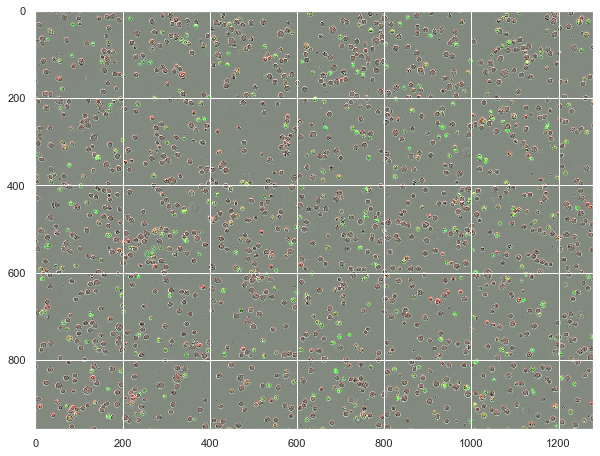

In [6]:
from src.vis_utils import visualise_rgb

img = imgs[0]
image = visualise_rgb(img[..., 0], img[..., 1], img[..., 2])

fig, ax = plt.subplots(figsize=(10, 15))
ax.imshow(image, cmap='Greys')

## Pipeline

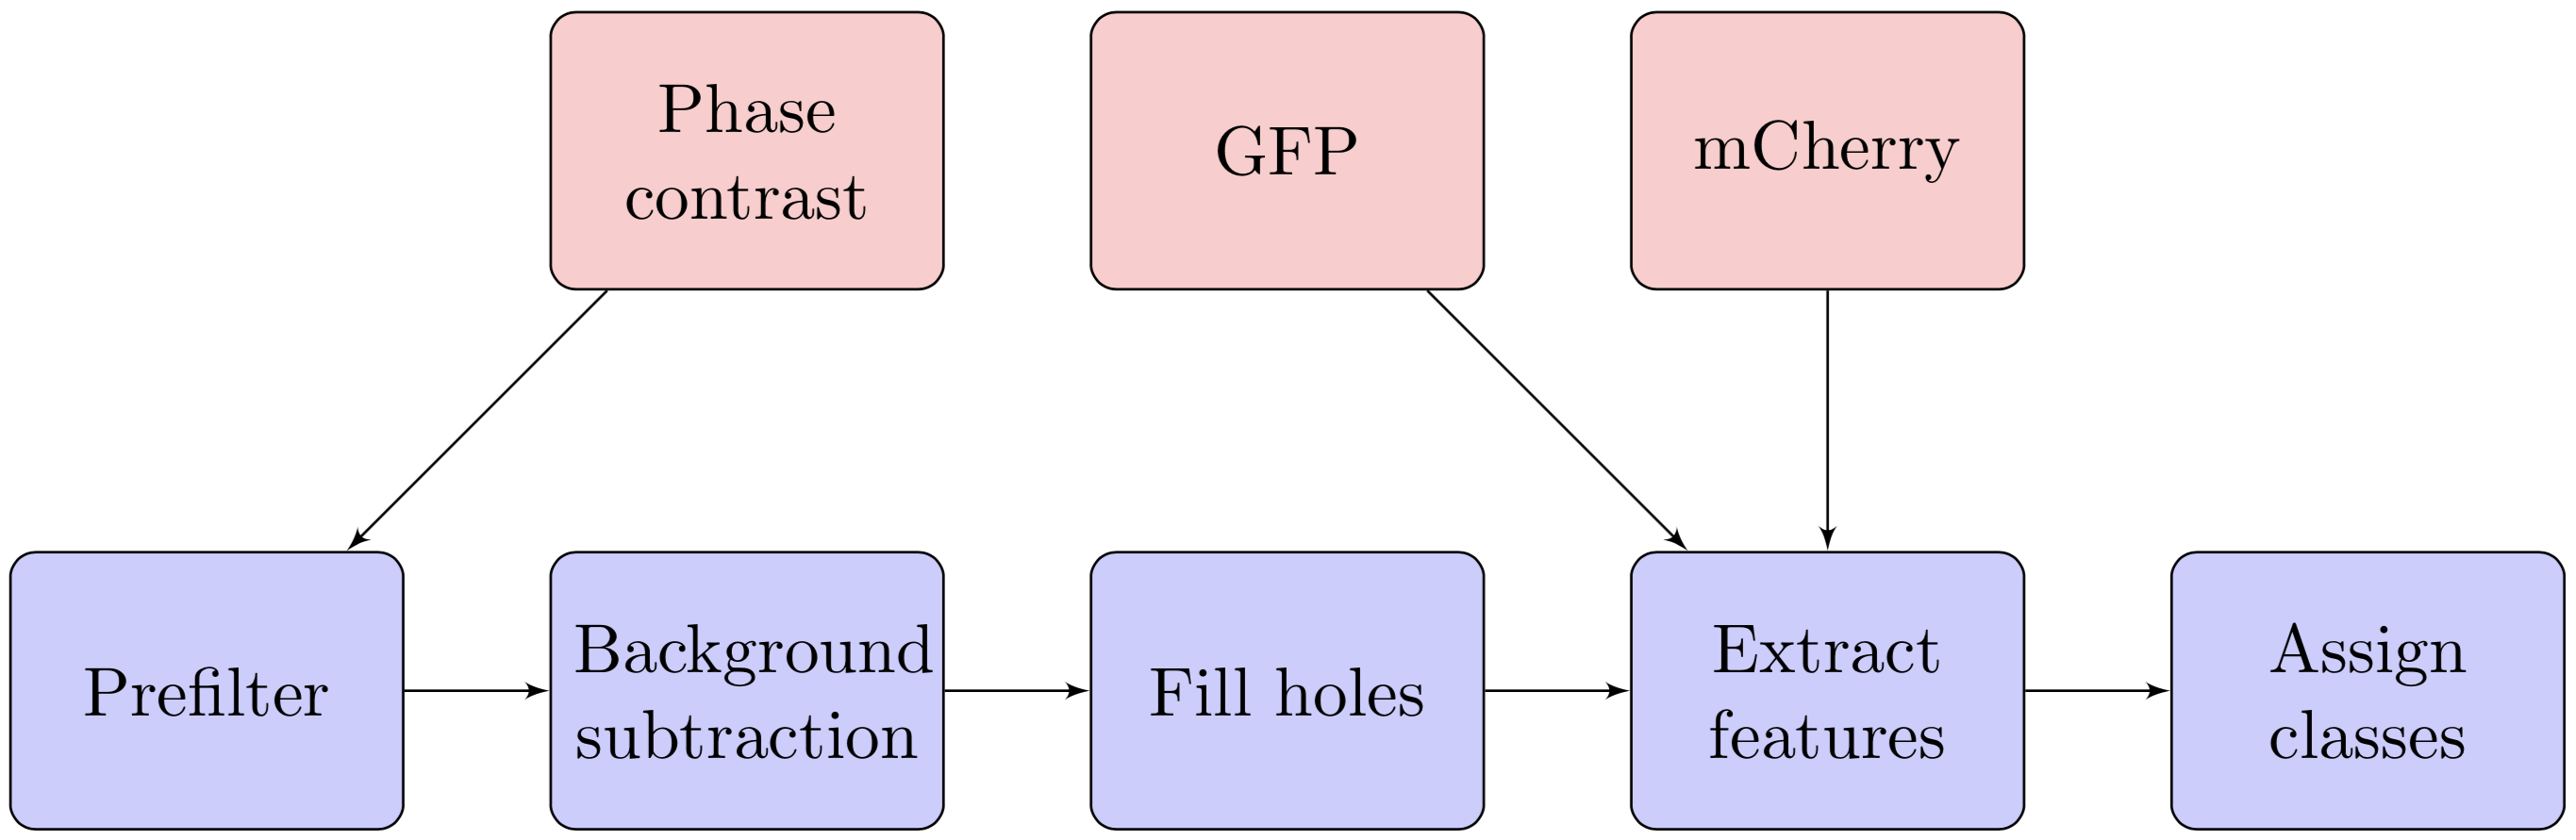

In [7]:
Image('./img/pipeline.png')

### Separate channels

We take the image $f : Z^2 \to \mathbb{R}^3$ to be a sum of red spectrum, green spectrum and phase contrast signals,
$$f(x) = r(x) + g(x) + pc(x)$$

for a pixel $x$, where pc(x), the phase contrast is constant across channels. Our colour pixels are therefore $f(x) = [r(x) + \alpha, g(x) + \alpha, \alpha]$. Thus, the blue channel corresponds directly to the phase contrast and the red and green signals can be recovered by subtracting this from the others.

[]

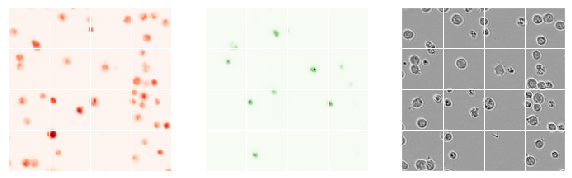

In [8]:
from src.pipeline import separate_channels
r, g, b = separate_channels(img)

crop = 200

fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(1, 3, 1)
ax.imshow(r[:crop, :crop], cmap='Reds')
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(1, 3, 2)
ax.imshow(g[:crop, :crop], cmap='Greens')
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(1, 3, 3)
ax.imshow(b[:crop, :crop], cmap='Greys_r')
ax.set_xticklabels([])
ax.set_yticklabels([])

### Prefiltering

A Gaussian blur will create locally more homogenous regions, which will be better suited to subsequent clustering algorithm, by rendering the bimodality of the intensity histograms more stark. It also helps to avoid acquired holes in connected components after thresholding.

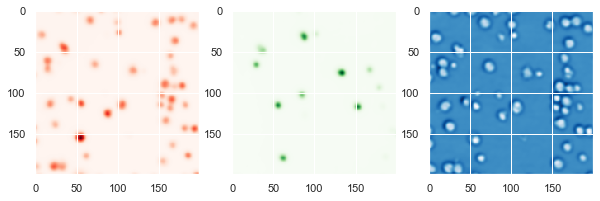

In [9]:
from src.pipeline import prefilter

mcherry, gfp, phase_contrast = map(lambda x : prefilter(x, sigma=filter_delta), (r, g, b))

fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(1, 3, 1)
ax.imshow(mcherry[:crop, :crop], cmap='Reds')

ax = fig.add_subplot(1, 3, 2)
ax.imshow(gfp[:crop, :crop], cmap='Greens')

ax = fig.add_subplot(1, 3, 3)
ax.imshow(phase_contrast[:crop, :crop], cmap='Blues')

### Background subtraction

We segment by subtracting a background image formed with a mean filter, before clipping to zero. We then fill object holes with a reconstruction by erosion. Finally, we use an opening to remove small objects and label connected components.

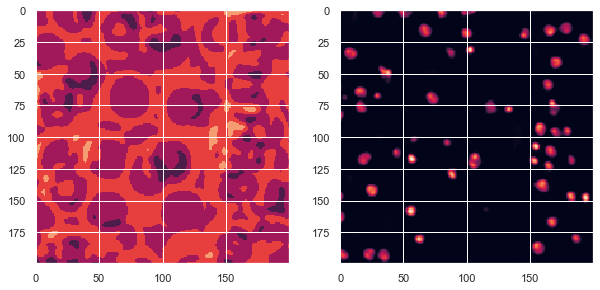

In [10]:
from src.pipeline import background_subtraction

background, segmentation = background_subtraction(phase_contrast, diameter=15)

fig, axes = plt.subplots(figsize=(10, 6), ncols=2)
axes[0].imshow(background[:crop, :crop])
axes[1].imshow(segmentation[:crop, :crop])

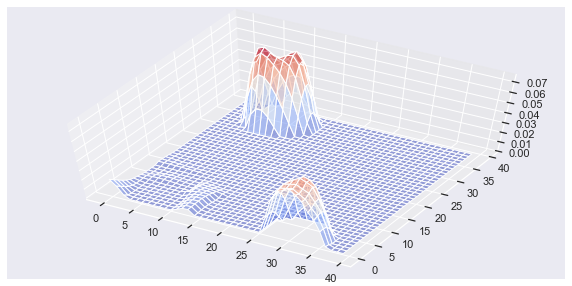

In [11]:
from mpl_toolkits.mplot3d import Axes3D

length = 40
X, Y = np.meshgrid(np.arange(length), np.arange(length))

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.plot_surface(X, Y, segmentation[:length, :length], alpha=0.5, cmap=plt.cm.coolwarm)
ax.view_init(60)

### Fill holes

The reconstruction by erosion is here done by creating a sheet as large as the image, having a 
constant value set to the highest intensity of the image, and finally zero-padded. The sheet is then continuously eroded (from the zero-padded region inwards), with the constraint that it is lower-bounded by the original mask. Once the wave of erosion reaches an object's contours, the sheet does not erode, due to the constraint. Subsequent erosions are performed within the contours, where all values are non-zero, thus having no eroding effect and "filling-in" the holes, forming a connected component.

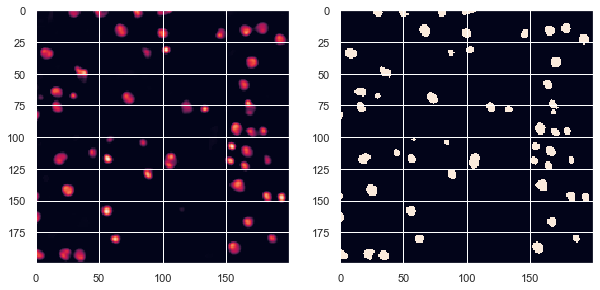

In [12]:
from src.pipeline import fill_holes

fill, mask, opened = fill_holes(segmentation, )

fig, axes = plt.subplots(figsize=(10, 6), ncols=2)
axes[0].imshow(fill[:200, :200])
axes[1].imshow(mask[:200, :200])

### Label connected components

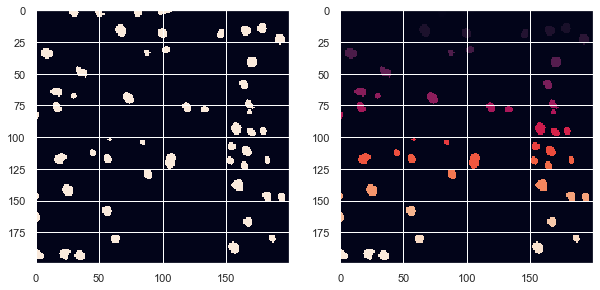

In [13]:
from src.pipeline import label_connected_components

labels = label_connected_components(opened)

fig, axes = plt.subplots(figsize=(10, 6), ncols=2)
axes[0].imshow(opened[:200, :200])
axes[1].imshow(labels[:200, :200])

### Object classification

Precision is more important than recall...

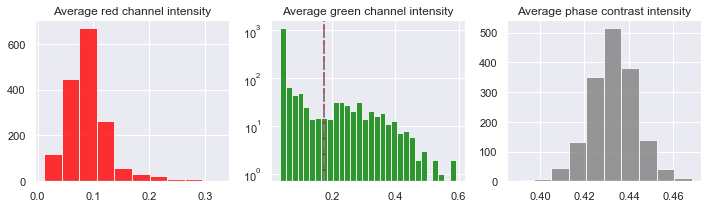

In [14]:
""" compute per-cell intensity averages on red and green channels """
from src.pipeline import extract_features
from skimage.filters import threshold_otsu

regions, df_features = extract_features(mcherry, gfp, phase_contrast, labels)
otsu_gfp = threshold_otsu(df_features.mean_green)

fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(1, 3, 1, title='Average red channel intensity')
_ = ax.hist(df_features.mean_red, color='red', alpha=0.8)

ax = fig.add_subplot(1, 3, 2, title='Average green channel intensity')
_ = ax.hist(df_features.mean_green, color='green', alpha=0.8, bins=30)
ax.set_yscale('log')

ax.axvline(otsu_gfp, color='red', linestyle='--')
ax.axvline(otsu_gfp - gfp_delta, color='gray', linestyle='-.')
ax.axvline(otsu_gfp + gfp_delta, color='gray', linestyle='-.')

ax = fig.add_subplot(1, 3, 3, title='Average phase contrast intensity')
_ = ax.hist(df_features.mean_pc, color='grey', alpha=0.8)

plt.tight_layout()

/Users/jcboyd/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/jcboyd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


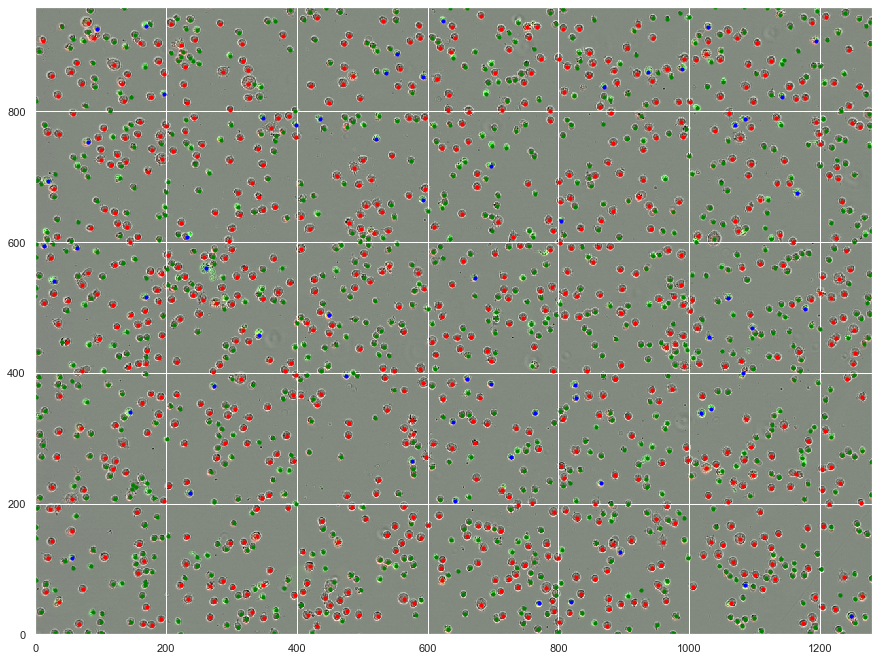

In [15]:
from src.pipeline import assign_classes

df_features = assign_classes(df_features, mode, gfp_delta)
image = visualise_rgb(r, g, b)

fig, ax = plt.subplots(figsize=(15, 15))

ax.imshow(image)
ax.set_ylim([0, image.shape[0]])
ax.set_xlim([0, image.shape[1]])

coords = df_features[['y', 'x']].as_matrix()

class0 = coords[df_features['class'] == 1]
ax.scatter(class0[:, 1], class0[:, 0], color='red', s=10)

class1 = coords[df_features['class'] == 2]
ax.scatter(class1[:, 1], class1[:, 0], color='blue', s=10)

class2 = coords[df_features['class'] == 3]
ax.scatter(class2[:, 1], class2[:, 0], color='green', s=10)

In [16]:
print('No. class 1: %d' % len(class0))
print('No. class 2: %d' % len(class1))
print('Unclassified: %d' % len(class2))

No. class 1: 687
No. class 2: 61
Unclassified: 880


In [17]:
from src.pipeline import run_pipeline

start_time = time.time()

pls = [{key : val for key, val in run_pipeline(img, mode, gfp_delta)} for img in imgs]

end_time = time.time()
print('Runtime: %.02fs' % (end_time - start_time))

Runtime: 200.83s


i.e. GFP is correlated with cell size, but not at all with mCherry. N.B. a density plot is tricky because of the relatively small number of dead cells (there's no such thing as a log scale on the z-axis).

In [32]:
raji_areas = []
dead_areas = []

for pl in pls:
    df_features = pl['features'][1]
    raji_areas.extend(list(df_features.area[df_features['class'] == 1]))
    dead_areas.extend(list(df_features.area[df_features['class'] == 2]))

raji_radii = np.sqrt(np.array(raji_areas) / np.pi)
dead_radii = np.sqrt(np.array(dead_areas) / np.pi)

print('\mu = %.02f, \sigma = %.02f, min = %.02f, max = %.02f' % (
    np.mean(raji_radii), np.std(raji_radii), np.min(raji_radii), np.max(raji_radii)))
print('\mu = %.02f, \sigma = %.02f, min = %.02f, max = %.02f' % (
    np.mean(dead_radii), np.std(dead_radii), np.min(dead_radii), np.max(dead_radii)))

num_raji = len(raji_radii)
num_dead = len(dead_radii)

print('p(dead) = %d : %d = %.01f' % (num_dead, num_raji, (num_dead) / (num_dead + num_raji)))

\mu = 4.84, \sigma = 0.94, min = 3.09, max = 9.84
\mu = 3.46, \sigma = 0.58, min = 2.03, max = 7.36
p(dead) = 14445 : 60783 = 0.2


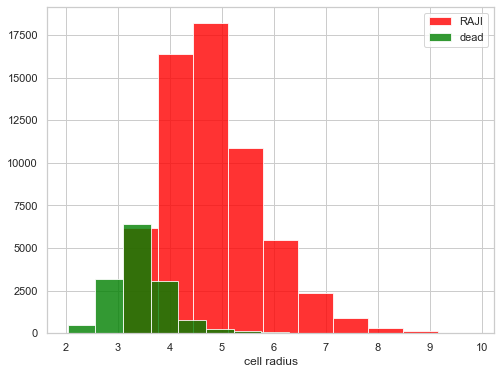

In [35]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(raji_radii, color='red', alpha=0.8, label='RAJI')
ax.hist(dead_radii, color='green', alpha=0.8, label='dead')

ax.set_xlabel('cell radius')
plt.legend()

## Weakly supervised object detection dataset

In [21]:
from skimage.io import imsave

crop_size = 256
crop_idx = 0

for pl in pls:

    phase_contrast = pl['channels'][2]
    class_masks, instance_masks = pl['class_masks']

    for y in range(0, phase_contrast.shape[0] - crop_size, crop_size):
        for x in range(0, phase_contrast.shape[1] - crop_size, crop_size):

            pc_crop = phase_contrast[y:y+crop_size, x:x+crop_size]
            imsave('./object_detection/images/%04d.png' % crop_idx, pc_crop)

            instance_crop = instance_masks[0][y:y+crop_size, x:x+crop_size]
            imsave('./object_detection/masks/%04d_cls1.png' % crop_idx, instance_crop)
            instance_crop = instance_masks[1][y:y+crop_size, x:x+crop_size]
            imsave('./object_detection/masks/%04d_cls2.png' % crop_idx, instance_crop)

#             pc_crop = phase_contrast[y:y+crop_size, x:x+crop_size]
#             imsave('./images/%04d' % crop_idx, pc_crop)

            crop_idx += 1

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/jcboyd/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./object_detection/masks/0000_cls1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 154]. Convert image to uint8 prior to saving to suppress this warning.
/Users/jcboyd/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./object_detection/masks/0000_cls2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 15]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/jcboyd/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./object_detection/masks/0001_cls1.png is a l

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/jcboyd/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./object_detection/masks/0011_cls1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 504]. Convert image to uint8 prior to saving to suppress this warning.
/Users/jcboyd/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./object_detection/masks/0011_cls2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 62]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/jcboyd/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./object_detection/masks/0012_cls1.png is a l

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/jcboyd/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./object_detection/masks/0022_cls1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 539]. Convert image to uint8 prior to saving to suppress this warning.
/Users/jcboyd/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./object_detection/masks/0022_cls2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 96]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/jcboyd/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./object_detection/masks/0023_cls1.png is a l

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/jcboyd/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./object_detection/masks/0033_cls1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 544]. Convert image to uint8 prior to saving to suppress this warning.
/Users/jcboyd/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./object_detection/masks/0033_cls2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 126]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/jcboyd/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./object_detection/masks/0034_cls1.png is a 

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/jcboyd/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./object_detection/masks/0044_cls1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 640]. Convert image to uint8 prior to saving to suppress this warning.
/Users/jcboyd/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./object_detection/masks/0044_cls2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 140]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/jcboyd/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./object_detection/masks/0045_cls1.png is a 

ValueError: Max value == min value, ambiguous given dtype

## Ground truth creation

In [17]:
from src.ground_truth import export_crops, visualise_random_crops, extract_background_crops

# only process the frames we need
num_frames = 36
pad = 12

crops, crops_rgb, class_labels, bbs, all_props = export_crops(pls[:num_frames], pad=pad)
# np.save('./outputs/bbs_%s' % acquisition, all_props)

# remove dummy class samples
dummy_class = 3 if mode == 'two-class' else 4
idx = class_labels != dummy_class

crops = crops[idx]
crops_rgb = crops_rgb[idx]
class_labels = class_labels[idx]
bbs = bbs[idx]

print(crops.shape)
print(class_labels.shape)

(46983, 24, 24)
(46983,)


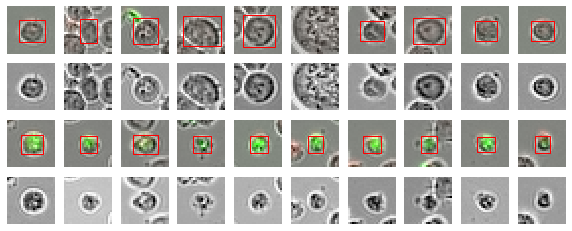

In [18]:
from src.vis_utils import visualise_random_crops

nb_classes = 2 if mode == 'two-class' else 3
visualise_random_crops(crops, crops_rgb, class_labels, bbs, pad, num_crops=10)

### Include background crops

In [19]:
nb_bg_crops = crops.shape[0] // num_frames

bg_data = [extract_background_crops(pl, nb_bg_crops, pad) for pl in pls[:num_frames]]
bg_crops = np.vstack(data[0] for data in bg_data)
bg_crops_rgb = np.vstack(data[1] for data in bg_data)

bg_labels = np.zeros(bg_crops.shape[0])
bg_bbs = np.zeros((bg_crops.shape[0], 2))

/Users/jcboyd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.
/Users/jcboyd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


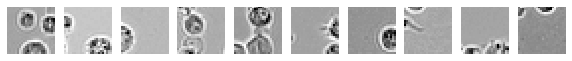

In [20]:
fig = plt.figure(figsize=(10, 2))

num_samples = 10

for i in range(num_samples):
    ax = fig.add_subplot(1, num_samples, i + 1)
    ax.imshow(bg_crops[np.random.randint(bg_crops.shape[0])], 'Greys_r')
    ax.axis('off')

### Export all crops

In [21]:
x_train = np.concatenate([crops, bg_crops])
y_train = np.concatenate([class_labels, bg_labels])
bbs_train = np.concatenate([bbs, bg_bbs])

y_train_one_hot = (y_train[:, None] == np.arange(3)).astype('float32')
y_train_full = np.hstack([y_train_one_hot, bbs_train])

np.save('./x_train_%s_%s' % (acquisition, mode), x_train)
np.save('./y_train_%s_%s' % (acquisition, mode), y_train_full)

x_train_rgb = np.concatenate([crops_rgb, bg_crops_rgb])

np.save('./x_train_%s_%s_rgb' % (acquisition, mode), x_train_rgb)
np.save('./y_train_%s_%s_rgb' % (acquisition, mode), y_train_full)